# COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [35]:
#keep repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [51]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
plt.style.use('ggplot')

In [52]:
#remove annoying worning about pandas assignment
pd.options.mode.chained_assignment = None

In [53]:
from sklearn.linear_model import LinearRegression,HuberRegressor,Ridge
lr = LinearRegression()

# Load national dataset

In [54]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
for c in ['nuovi_attualmente_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]:
    
    df[c+'_log']=np.log10(df[c])

## Fig1

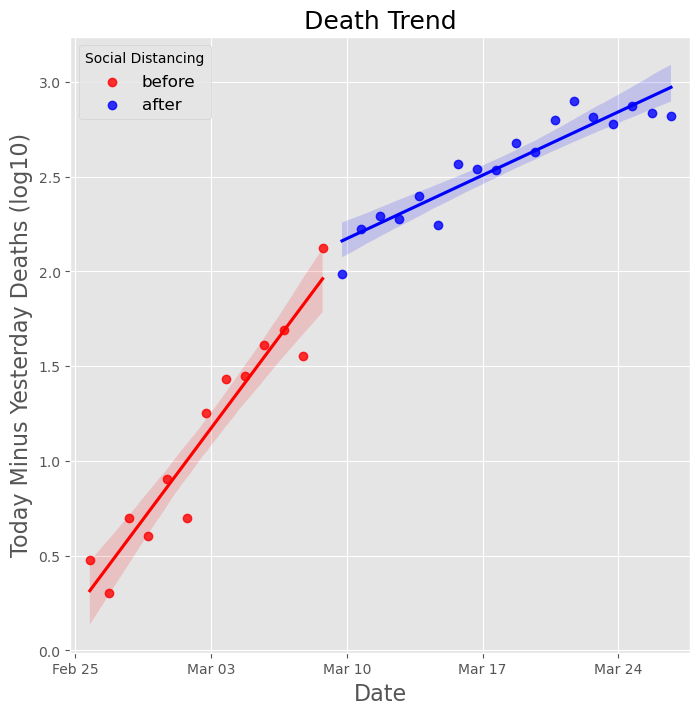

In [64]:
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[df['data']>'2020-03-9']
after['ndata']=date2num(after['data'])

x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='after')

xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-1,xmax+1)
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Social Distancing',fontsize=12)
plt.savefig('Fig1.png')
plt.show()

## Fig2

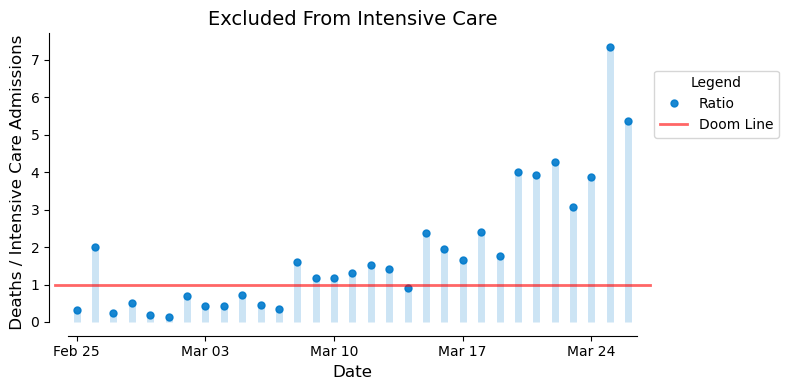

In [31]:

plt.style.use('default')


fig,ax=plt.subplots(figsize=(8,4))
ax.plot(df['data'].dt.date, df['not_admitted_ratio'], "o",
        markersize=5, color='#007acc', alpha=0.9,label='Ratio')
ax.vlines(x=df['data'].dt.date, ymin=0, 
          ymax=df['not_admitted_ratio'], color='#007acc', alpha=0.2, linewidth=5)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#designdate='March 08 2020 13:00'
#ax.axvline(pd.to_datetime(designdate), ymin=0.1,ymax=0.9,linewidth=2)

xtickslocs = ax.get_xticks()
xmin, xmax = ax.get_xlim()

ax.axhline(1, xmin=0.01,xmax=0.99,
           linewidth=2,color='r',alpha=0.6,label='Doom Line')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(0, ymax)


xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_bounds(xmin+1, xmax-1)

plt.xlabel('Date', fontsize='12')
plt.ylabel(' Deaths / Intensive Care Admissions', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.tight_layout()
plt.savefig('Fig2.png')
plt.show()

## Fig3

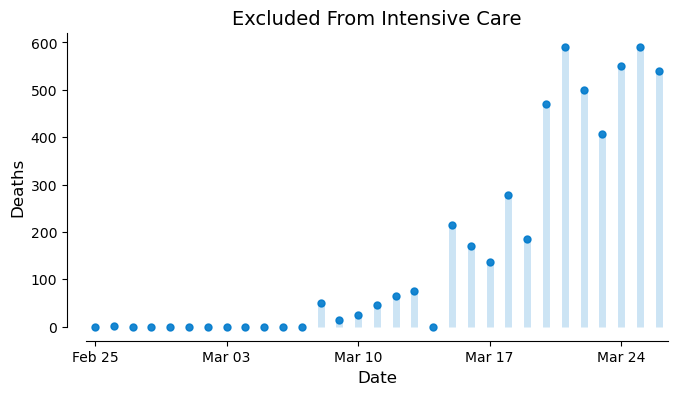

In [42]:
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('default')
#df['data']=df['data'].dt.to_period('D')

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(df['data'].dt.date, df['not_admitted'].clip(lower=0),
        "o", markersize=5, color='#007acc', alpha=0.9,label='Ratio')
ax.vlines(x=df['data'].dt.date, ymin=0, ymax=df['not_admitted'].clip(lower=0), 
          color='#007acc', alpha=0.2, linewidth=5)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
designdate='March 08 2020 13:00'
#ax.axvline(pd.to_datetime(designdate), ymin=0.1,ymax=0.9,linewidth=2)

xtickslocs = ax.get_xticks()
xmin, xmax = ax.get_xlim()


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(0, ymax)


xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_bounds(xmin+1, xmax-1)

plt.xlabel('Date', fontsize='12')
plt.ylabel('Deaths', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

#plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.savefig('Fig3.png')
plt.show()

In [65]:
!jupyter nbconvert --to html_toc DataVis.ipynb

[NbConvertApp] Converting notebook DataVis.ipynb to html_toc
[NbConvertApp] Support files will be in DataVis_files/
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Writing 310291 bytes to DataVis.html


In [67]:
!git add DataVis*
!git add -u
!git commit -m 'simplify fig1 with seaborn'
!git push -u origin master


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'mtinti@ls29490.(none)')
fatal: unable to access 'https://github.com/mtinti/COVID-19.git/': Could not resolve host: github.com


In [ ]:
git config --global user.email "you@example.com"